
#      **Parking Spot Detection Using YOLOV8**





**Install necessary libraries**

In [ ]:
!pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 11.9 MB/s eta 0:00:00


**Mount Google Drive to access dataset and save files**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extract the dataset**

In [ ]:
import zipfile
import os

In [ ]:
zip_file_path = '/content/drive/MyDrive/PKLot.v2-640.yolov8.zip'
extract_path = '/content/dataset'
os.makedirs(extract_path, exist_ok=True)


In [ ]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Files in extracted dataset folder:", os.listdir(extract_path))

Files in extracted dataset folder: ['valid', 'test', 'data.yaml', 'README.roboflow.txt', 'README.dataset.txt', 'train']














**Count images in each set**

In [ ]:
train_dir = '/content/dataset/train/images'
valid_dir = '/content/dataset/valid/images'
test_dir = '/content/dataset/test/images'

In [ ]:
train_images = len([name for name in os.listdir(train_dir) if name.endswith('.jpg') or name.endswith('.png')])
valid_images = len([name for name in os.listdir(valid_dir) if name.endswith('.jpg') or name.endswith('.png')])
test_images = len([name for name in os.listdir(test_dir) if name.endswith('.jpg') or name.endswith('.png')])


In [ ]:
print(f"Training images: {train_images}, Validation images: {valid_images}, Test images: {test_images}")


Training images: 8691, Validation images: 2483, Test images: 1242


In [ ]:
total_images = train_images + valid_images + test_images
print(f"Total number of images: {total_images}")

Total number of images: 12416


In [ ]:
train_percentage = (train_images / total_images) * 100
val_percentage = (valid_images / total_images) * 100
test_percentage = (test_images / total_images) * 100

In [ ]:
print(f"Training Set: {train_images} images ({train_percentage:.2f}%)")
print(f"Validation Set: {valid_images} images ({val_percentage:.2f}%)")
print(f"Test Set: {test_images} images ({test_percentage:.2f}%)")

Training Set: 8691 images (70.00%)
Validation Set: 2483 images (20.00%)
Test Set: 1242 images (10.00%)


**Get class distribution in training set**

In [ ]:
from collections import Counter


In [ ]:
def get_class_distribution(dataset_path):
    label_path = os.path.join(dataset_path, 'train/labels')
    all_labels = []
    for label_file in os.listdir(label_path):
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                all_labels.append(class_id)
    return Counter(all_labels)

In [ ]:
dataset_path = '/content/dataset'
class_distribution = get_class_distribution(dataset_path)
print("Class distribution in training set:", class_distribution)

Class distribution in training set: Counter({0: 265908, 1: 231948})


**Sample image visualization with bounding boxes**

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
def plot_sample_images(dataset_path, num_samples=3):
    image_folder = os.path.join(dataset_path, 'train/images')
    label_folder = os.path.join(dataset_path, 'train/labels')
    sample_images = os.listdir(image_folder)[:num_samples]

    for image_name in sample_images:
        image_path = os.path.join(image_folder, image_name)
        label_path = os.path.join(label_folder, image_name.replace('.jpg', '.txt'))
        image = cv2.imread(image_path)
        height, width, _ = image.shape

        with open(label_path, 'r') as file:
            for line in file:
                class_id, x, y, w, h = map(float, line.split())
                x1 = int((x - w / 2) * width)
                y1 = int((y - h / 2) * height)
                x2 = int((x + w / 2) * width)
                y2 = int((y + h / 2) * height)
                color = (0, 255, 0) if class_id == 0 else (0, 0, 255)  # Green for empty, red for occupied
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Sample Image - {image_name}")
        plt.axis('off')
    plt.show()


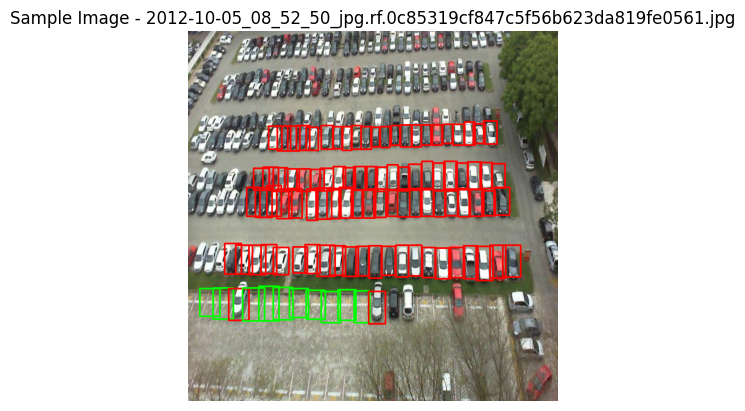

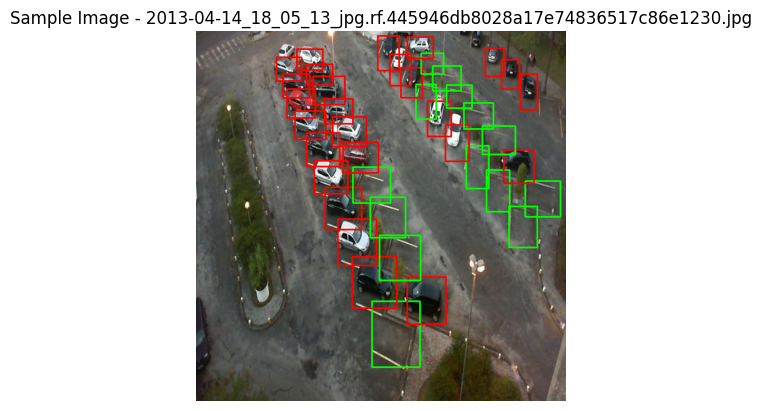

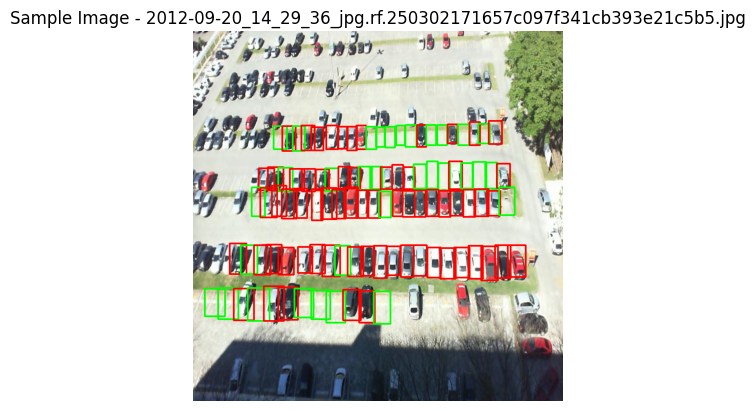

In [ ]:
plot_sample_images(dataset_path)

**Image Size and Their Frequency**

**Bounding Box Size and Position Analysis**

In [ ]:
import numpy as np

In [ ]:
def analyze_bbox_sizes(dataset_path):
    label_folder = os.path.join(dataset_path, 'train/labels')
    bbox_widths, bbox_heights = [], []

    for label_file in os.listdir(label_folder):
        with open(os.path.join(label_folder, label_file), 'r') as file:
            for line in file:
                _, x, y, w, h = map(float, line.split())
                bbox_widths.append(w)
                bbox_heights.append(h)

    plt.figure()
    plt.hist(bbox_widths, bins=20, alpha=0.5, label='Widths')
    plt.hist(bbox_heights, bins=20, alpha=0.5, label='Heights')
    plt.xlabel('Relative Size (0 to 1)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title("Bounding Box Size Distribution")
    plt.show()

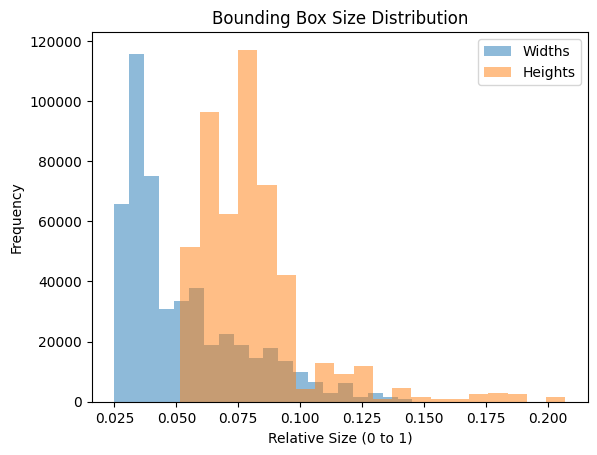

In [ ]:
analyze_bbox_sizes(dataset_path)

**Create YOLOv8 configuration file**

In [ ]:
dataset_yaml_content = """
path: /content/dataset
train: train/images
val: valid/images
test: test/images

nc: 2  # Number of classes (e.g., 'empty', 'occupied')
names: ['empty', 'occupied']
"""

with open('/content/dataset.yaml', 'w') as f:
    f.write(dataset_yaml_content)
print("Created dataset.yaml!")

Created dataset.yaml!


**Load and Train YOLOv8 Model**

In [ ]:
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO('/content/drive/MyDrive/yolov8_parking_spot_model2original.pt')

In [ ]:
model.train(data='/content/dataset.yaml', epochs=30, imgsz=640)

**Train the model**

**Evaluate model performance**

In [ ]:
results = model.val(data='/content/dataset.yaml')
print(results)

Ultralytics 8.3.33 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


100%|██████████| 755k/755k [00:00<00:00, 25.7MB/s]
val: Scanning /content/dataset/valid/labels... 2483 images, 59 backgrounds, 0 corrupt: 100%|██████████| 2483/2483 [00:01<00:00, 1247.24it/s]


val: New cache created: /content/dataset/valid/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 156/156 [00:50<00:00,  3.12it/s]


                   all       2483     143316      0.998      0.999      0.995      0.979
                 empty       2062      73629      0.998      0.998      0.995      0.983
              occupied       1967      69687      0.998      0.999      0.994      0.974
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0d80289a20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.

**Save the trained model**

In [ ]:
model.save('/content/drive/MyDrive/yolov8_parking_spot_model2original.pt')
print("Model saved successfully to Google Drive!")

Model saved successfully to Google Drive!


In [ ]:
# Define the preprocessing function
def sharpen_image(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")

    # Define a sharpening kernel
    sharpening_kernel = np.array([[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]])

    # Apply the sharpening filter
    sharpened = cv2.filter2D(image, -1, sharpening_kernel)

    # Return the sharpened image
    return sharpened

In [ ]:
test_image_path = ''
sharpened_image = sharpen_image(test_image_path)

ValueError: Image not found at /content/dip[1].jpg

In [ ]:
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.title("Sharpened Image")
plt.axis("off")
plt.show()

NameError: name 'sharpened_image' is not defined


image 1/1 /content/dataset/valid/images/sharpened_image.jpg: 128x640 (no detections), 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 128, 640)


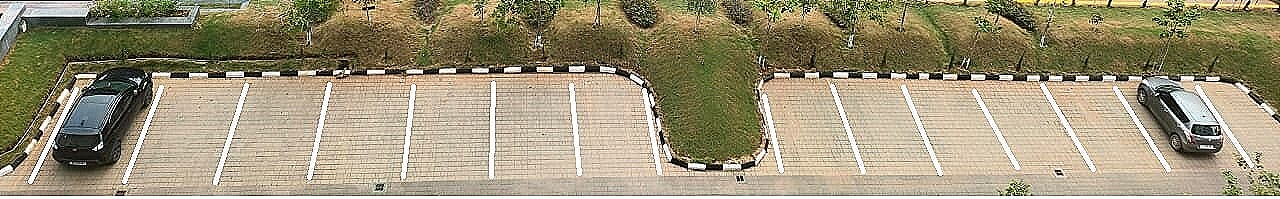

In [ ]:
sharpened_image_path = '/content/dataset/valid/images/sharpened_image.jpg'
cv2.imwrite(sharpened_image_path, sharpened_image)

# Pass the sharpened image to the model
results = model.predict(source=sharpened_image_path)
result = results[0]
result.show()

In [ ]:
boxes = result.boxes
classes = boxes.cls

num_empty_spots = (classes == 0).sum().item()
num_occupied_spots = (classes == 1).sum().item()
print(f"Number of empty parking spots: {num_empty_spots}")
print(f"Number of occupied parking spots: {num_occupied_spots}")

Number of empty parking spots: 0
Number of occupied parking spots: 0


**Visualize detections with color enhancements**

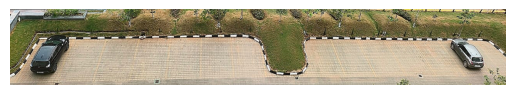

In [ ]:
detected_image = result.plot()

# Display the detection
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

**Further enhance image quality with contrast adjustment**

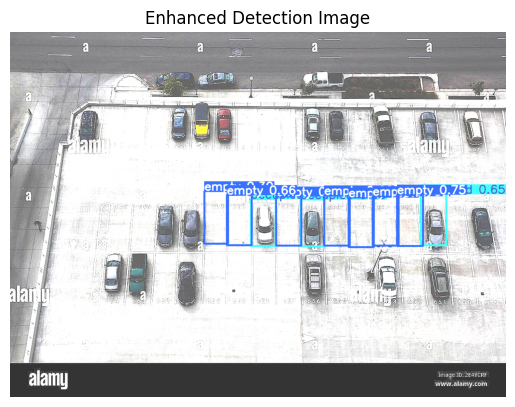

In [ ]:
def adjust_brightness_contrast(image, brightness=50, contrast=1.5):
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
    return adjusted_image

enhanced_image = adjust_brightness_contrast(detected_image)
plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Enhanced Detection Image")
plt.show()

In [ ]:
from IPython.display import Image, display

In [ ]:
from IPython import display

**Color coding**

In [ ]:
detected_image = result.plot()

In [ ]:
for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    color = (0, 255, 0) if box.cls == 0 else (0, 0, 255)
    cv2.rectangle(detected_image, (x1, y1), (x2, y2), color, 2)

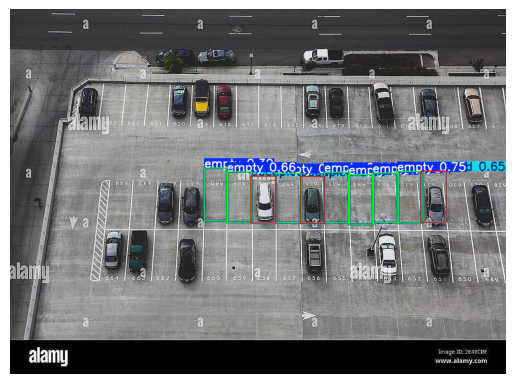

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

**Sharpening**

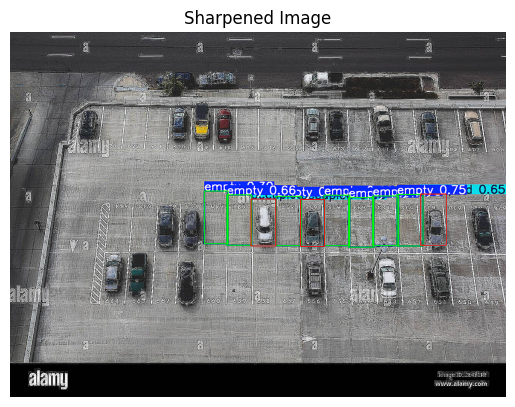

In [ ]:
kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
sharpened_image = cv2.filter2D(detected_image, -1, kernel)

# Display the sharpened image
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Sharpened Image")
plt.show()

**Color Enchanced Image**

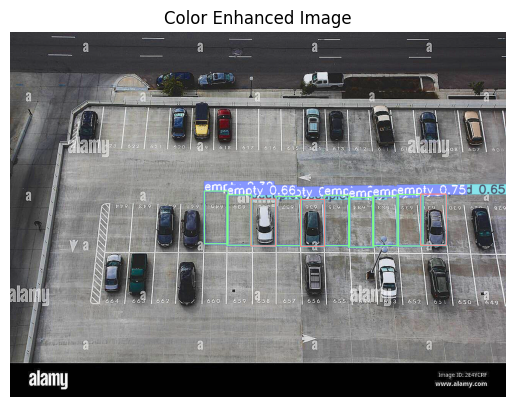

In [ ]:
# Convert to HSV (Hue, Saturation, Value) color space
hsv_image = cv2.cvtColor(detected_image, cv2.COLOR_BGR2HSV)

# Increase saturation to make colors more vivid
hsv_image[..., 1] = hsv_image[..., 1] * 1.5  # Increase saturation

# Convert back to BGR color space
enhanced_color_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

# Display the color-enhanced image
plt.imshow(cv2.cvtColor(enhanced_color_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Color Enhanced Image")
plt.show()

**Brightness and Contrast Enhanced**

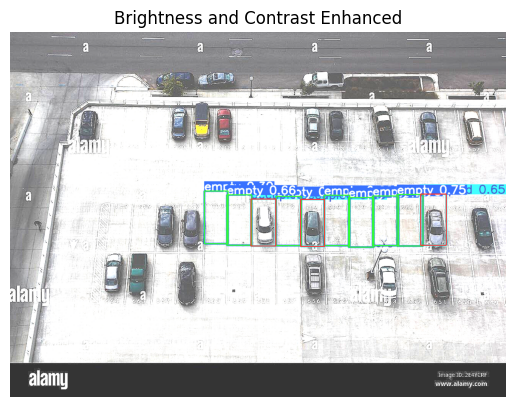

In [ ]:
def adjust_brightness_contrast(image, brightness=0, contrast=0):
    # Apply brightness and contrast adjustments
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
    return adjusted_image

# Apply adjustments
enhanced_image = adjust_brightness_contrast(detected_image, brightness=50, contrast=1.5)

# Display the enhanced image
plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Brightness and Contrast Enhanced")
plt.show()

In [ ]:
black_background = np.zeros_like(detected_image)

In [ ]:
boxes = result.boxes
classes = boxes.cls
confidences = boxes.conf

In [ ]:
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Box coordinates
    confidence = confidences[i].item()      # Confidence score for the box
    label = f"{confidence:.2f}"             # Format confidence score

    if classes[i] == 0:  # Empty spot
        outline_color = (0, 255, 0)  # Green outline for available spots
        text_color = (0, 255, 0)     # Green for text as well
    else:  # Occupied spot
        outline_color = (0, 0, 255)  # Red outline for occupied spots
        text_color = (0, 0, 255)     # Red for text as well

    # Draw only the outline of the bounding box without filling
    cv2.rectangle(black_background, (x1, y1), (x2, y2), outline_color, 2)  # Outline with thickness 2

    # Add the confidence label above the box
    cv2.putText(black_background, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1)


In [ ]:
    # Draw outline around each box with the specified color
    cv2.rectangle(black_background, (x1, y1), (x2, y2), outline_color, 2)

    # Display confidence score at the top-left corner of the bounding box
    cv2.putText(black_background, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

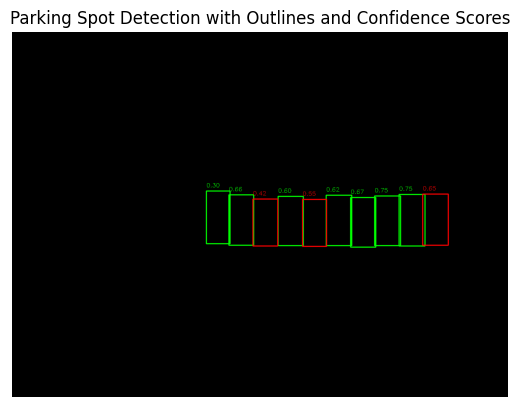

In [ ]:
plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Parking Spot Detection with Outlines and Confidence Scores")
plt.show()


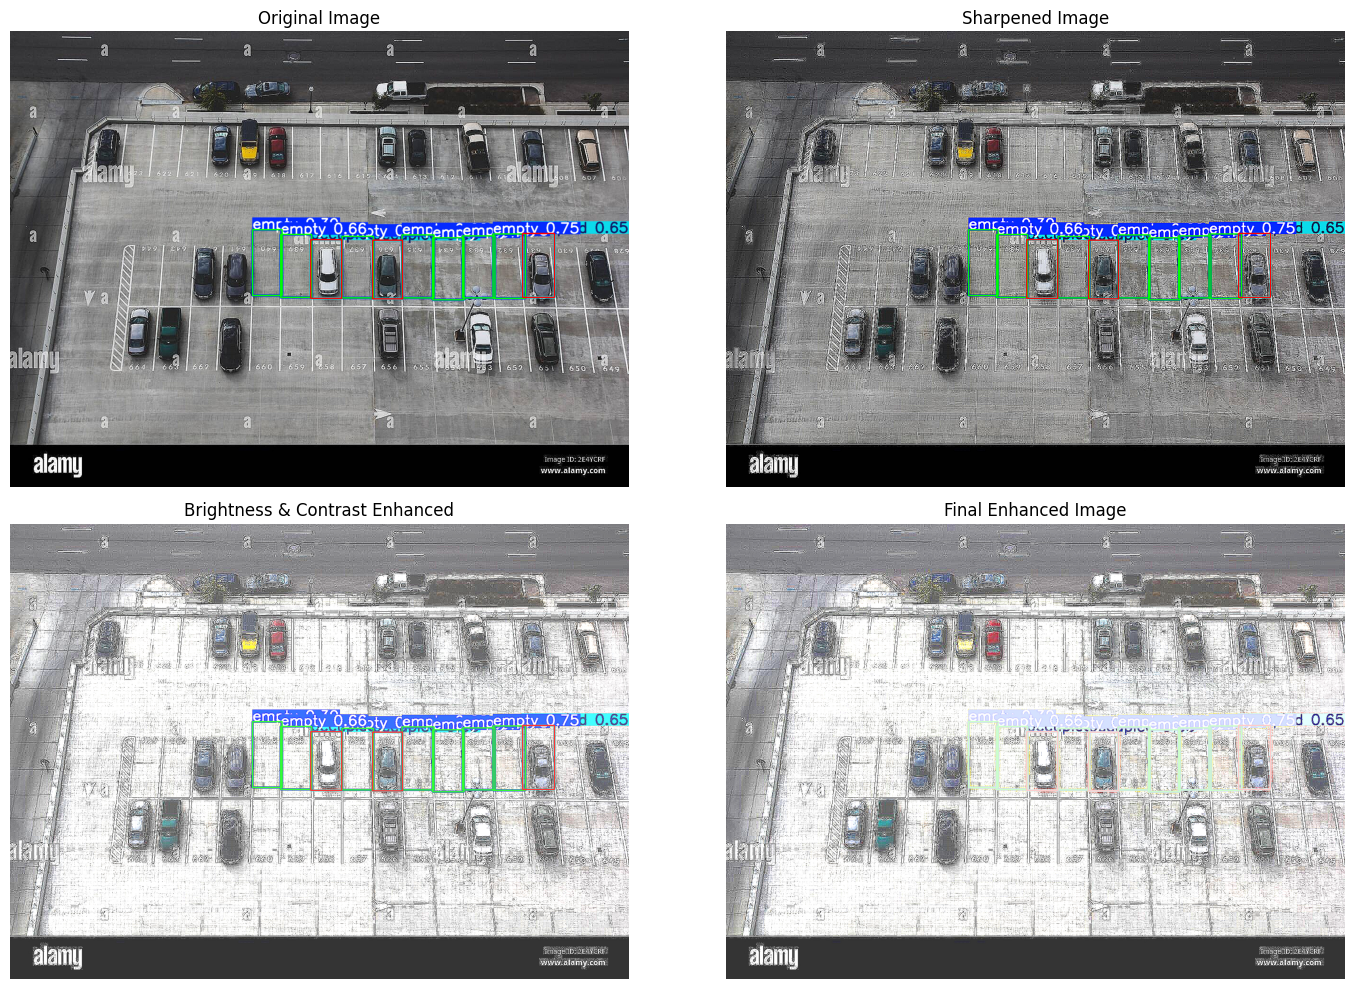

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image(image):
    """
    Processes an image through sharpening, brightness and contrast adjustment,
    and color enhancement. Displays the final output.

    Args:
        image: Input image (numpy array).
    Returns:
        final_image: The fully processed image.
    """
    # Step 1: Sharpen the image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(image, -1, kernel)

    # Step 2: Adjust brightness and contrast
    def adjust_brightness_contrast(image, brightness=50, contrast=1.5):
        return cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)

    brightness_contrast_enhanced = adjust_brightness_contrast(sharpened_image)

    # Step 3: Enhance color (increase saturation)
    hsv_image = cv2.cvtColor(brightness_contrast_enhanced, cv2.COLOR_BGR2HSV)
    hsv_image[..., 1] = hsv_image[..., 1] * 1.5  # Increase saturation
    enhanced_color_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    # Visualization
    titles = ["Original Image", "Sharpened Image",
              "Brightness & Contrast Enhanced", "Final Enhanced Image"]
    images = [image, sharpened_image, brightness_contrast_enhanced, enhanced_color_image]

    plt.figure(figsize=(15, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()

    return enhanced_color_image

# Example usage
# Replace `image_path` with the path to your input image

final_image = process_image(detected_image)


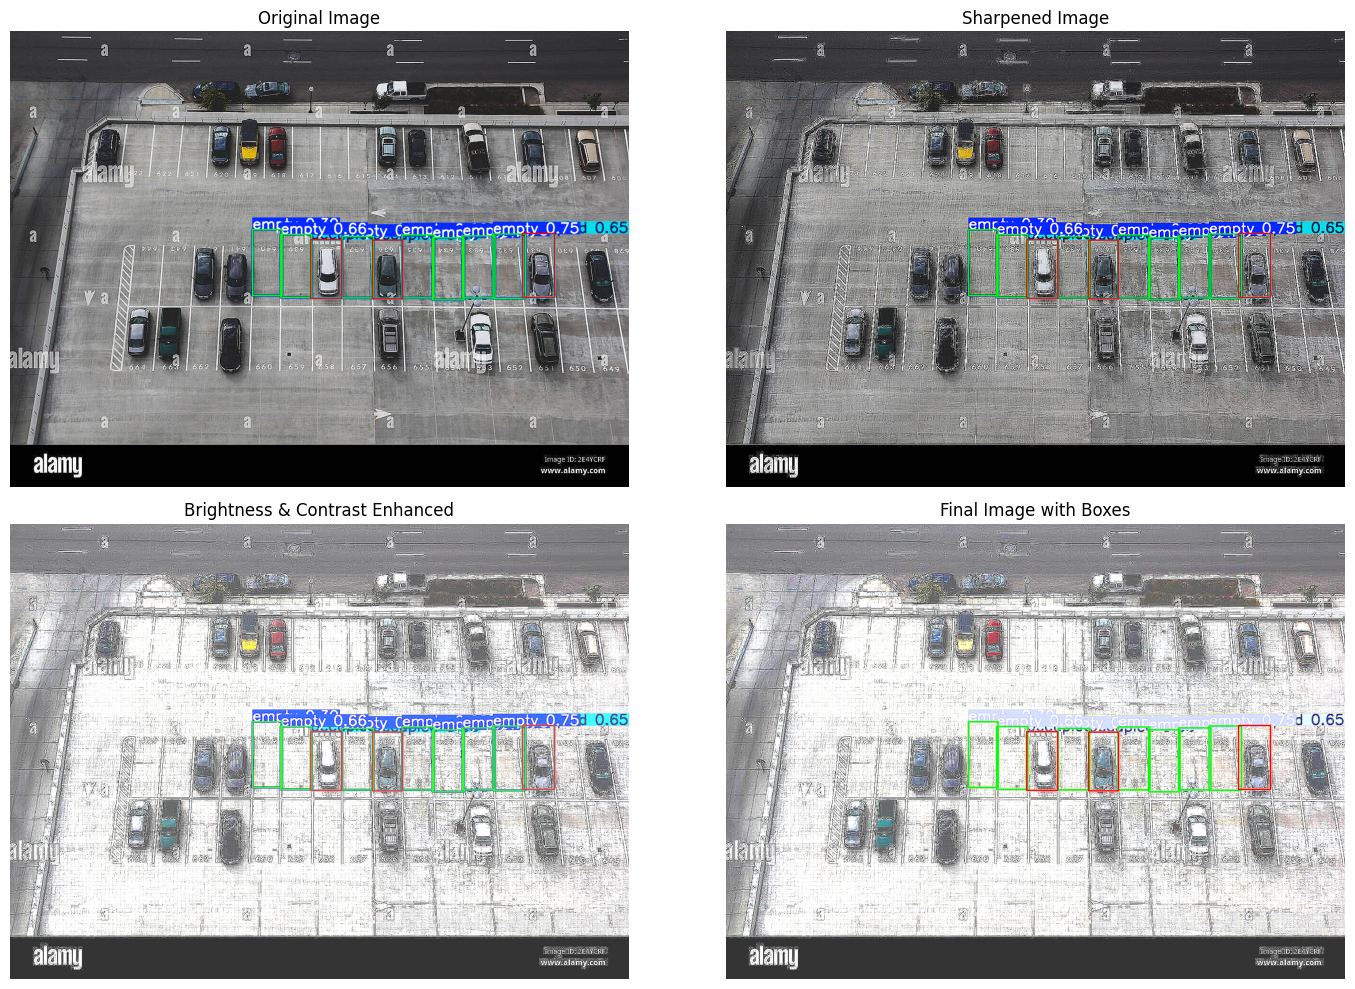

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image_with_boxes(image, boxes):
    """
    Processes an image through sharpening, brightness and contrast adjustment,
    color enhancement, and adds bounding boxes for visualization.

    Args:
        image: Input image (numpy array).
        boxes: Detected bounding boxes and class labels.
    Returns:
        final_image_with_boxes: The fully processed image with bounding boxes.
    """
    # Step 1: Sharpen the image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(image, -1, kernel)

    # Step 2: Adjust brightness and contrast
    def adjust_brightness_contrast(image, brightness=50, contrast=1.5):
        return cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)

    brightness_contrast_enhanced = adjust_brightness_contrast(sharpened_image)

    # Step 3: Enhance color (increase saturation)
    hsv_image = cv2.cvtColor(brightness_contrast_enhanced, cv2.COLOR_BGR2HSV)
    hsv_image[..., 1] = hsv_image[..., 1] * 1.5  # Increase saturation
    enhanced_color_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    # Step 4: Add bounding boxes
    final_image_with_boxes = enhanced_color_image.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
        color = (0, 255, 0) if box.cls == 0 else (0, 0, 255)  # Green for empty, red for occupied
        cv2.rectangle(final_image_with_boxes, (x1, y1), (x2, y2), color, 2)

    # Visualization
    titles = ["Original Image", "Sharpened Image",
              "Brightness & Contrast Enhanced", "Final Image with Boxes"]
    images = [image, sharpened_image, brightness_contrast_enhanced, final_image_with_boxes]

    plt.figure(figsize=(15, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()

    return final_image_with_boxes

# Example usage
# Assume `detected_image` is the input image, and `boxes` contains bounding box data
final_image_with_boxes = process_image_with_boxes(detected_image, boxes)
